# Exercise 5: Regularized Linear Regression and Bias vs. Variance

In this exercise, you will implement regularized linear regression and use it to
study models with different bias-variance properties. Before starting on the
programming exercise, we strongly recommend watching the video lectures
and completing the review questions for the associated topics

In [2]:
# libraries
# data handling
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# fit parameters
import scipy as sp

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

## Regularized Linear Regression
In the first half of the exercise, you will implement regularized linear regression to predict the amount of water flowing out of a dam using the change
of water level in a reservoir. In the next half, you will go through some diagnostics of debugging learning algorithms and examine the effects of bias v.s.
variance.

### Visualizing the dataset

We will begin by visualizing the dataset containing historical records on the
change in the water level, x, and the amount of water flowing out of the dam,
y.
This dataset is divided into three parts:
- A training set that your model will learn on: `X`, `y`
- A cross validation set for determining the regularization parameter:
`Xval`, `yval`
- A test set for evaluating performance. These are “unseen” examples
which your model did not see during training: `Xtest`, `ytest`

In [4]:
# import splitted data
dat = sp.io.loadmat("ex5/ex5data1.mat")
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [3]:
# Make data subsets variables
# training data
y = dat["y"]
X = np.c_[np.ones(len(y)),dat["X"]]  # add bias
# cross validation data
yval = dat["yval"]
Xval = np.c_[np.ones(len(yval)),dat["Xval"]] # add bias
# testing data
ytest = dat["ytest"]
Xtest = np.c_[np.ones(len(ytest)),dat["Xtest"]]  # add bias

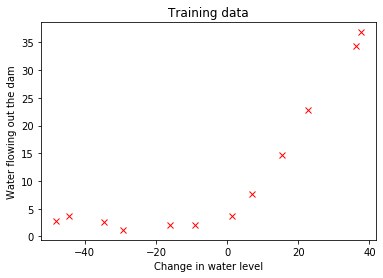

In [37]:
# visualize training data
plt.plot(X[:,1], y, "x",color='red')
plt.xlabel("Change in water level")
plt.ylabel("Water flowing out the dam")
plt.title("Training data")
plt.show()

### Regularized linear regression cost function

In [38]:
def linear_regression(theta, x):
    """
    Compute linear regression.
    """
    return x.dot(theta)


def reg_linreg_cost(theta, x, y, lbda):
    """
    Returns regularized mean squared error for a hypothesis function.
    """
    # save total observations
    m = len(y)

    # compute mean squared error
    mse = 1 / (2 * m) * np.sum((linear_regression(theta, x) - y) ** 2)

    # compute regularization term
    # reminder: bias parameter not included
    reg_term = lbda / (2 * m) * np.sum(theta[1::] ** 2)

    # compute cost function
    J = mse + reg_term
    
    return J

### Regularized linear regression gradient

In [39]:
def reg_linreg_gradient(theta, x, y, lbda):
    """
    Returns regularized value of the partial derivatives of the mean
    squared error cost function.
    """
    # save total observations
    m = len(y)

    # compute regularized gradients
    # compute non-regularized gradients
    J_nonreg = (1 / m) * x.T.dot(linear_regression(theta, x) - y)
    # compute regularization term
    J_reg_term = (lbda / m) * theta

    # add regularization term to all parameters but bias
    J_grad = J_nonreg
    J_grad[1::] = J_grad[1::] + J_reg_term[1::]

    return J_grad

### Fitting linear regression

In [40]:
def reg_linreg_fit(theta, x, y, lbda):
    """
    Fits model parameters to data according to our hypothesis,
    cost and gradient functions.
    """
    opt_weights = sp.optimize.minimize(
        fun=reg_linreg_cost,
        x0=theta,
        args=(x, y.flatten(), lbda),
        method="TNC",
        jac=reg_linreg_gradient,
    )
    return opt_weights

In [223]:
# set parameters
theta_init = np.zeros((X.shape[1],1))
lbda = 1

In [241]:
# see process
fitting_result = reg_linreg_fit(theta_init, X, y, lbda)
print(fitting_result)

# save optimized parameters
theta_opt = fitting_result["x"]
J_opt = fitting_result["fun"]

     fun: 22.379541822940272
     jac: array([ 1.04911294e-09, -1.27573463e-08])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 9
     nit: 4
  status: 0
 success: True
       x: array([13.08771416,  0.367742  ])


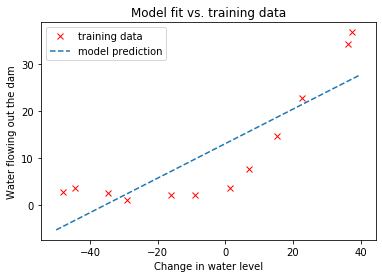

In [90]:
# visualize fit with training data
# plot training data
plt.plot(X[:, 1], y, "x", color="red")

# plot fit
x_coords = np.array([np.ones((25)), np.linspace(-50, 40, 25).reshape(25)]).T
plt.plot(x_coords[:, 1], linear_regression(theta_opt, x_coords), linestyle="dashed")

# complete plot information
plt.xlabel("Change in water level")
plt.ylabel("Water flowing out the dam")
plt.title("Model fit vs. training data")
plt.legend(labels=["training data", "model prediction"])
plt.show()

## Bias-variance
An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit,
while models with high variance overfit to the training data.

In this part of the exercise, you will plot training and test errors on a
learning curve to diagnose bias-variance problems.

### Learning curves

- **Number of training examples vs. Error:**

Pass [0,12] training examples to fit the model and plot the minimized error value for test and cross validation datasets.

In [126]:
def get_learning_curves(theta, x, y, lbda, x_val, y_val):
    """
    Return errors of training and cross validation data sets.
    """

    # init
    # training samples indexes
    rand_idx = np.arange(len(x))
    np.random.shuffle(rand_idx)
    # errors
    er_train = np.ones(len(x))
    er_val = np.ones(len(x))

    for set_size in range(12):
        # fit model
        tmp_result = reg_linreg_fit(
            theta,
            x[rand_idx[: (set_size + 1)], :],
            y[rand_idx[: (set_size + 1)], :],
            lbda,
        )
        tmp_thetaopt = tmp_result["x"]

        # compute and store errors for fitted model with subsetted training data
        er_train[set_size] = reg_linreg_cost(
            tmp_thetaopt,
            x[rand_idx[: (set_size + 1)], :],
            y[rand_idx[: (set_size + 1)], :],
            lbda,
        )
        
        # compute and store errors for fitted model with all cross validation data
        er_val[set_size] = reg_linreg_cost(
            tmp_thetaopt,
            x_val,
            y_val,
            lbda,
        )

    return {"er_train": er_train, "er_val": er_val}

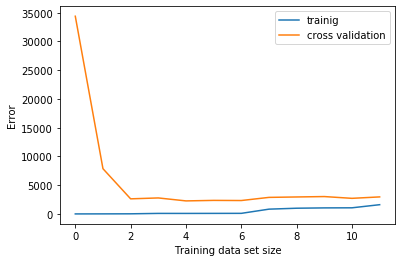

In [133]:
# compute learning curves
l_curves = get_learning_curves(theta_init, X, y, 0, Xval, yval) # not regularized

# visualize learning curves
plt.plot(l_curves["er_train"])
plt.plot(l_curves["er_val"])

plt.xlabel('Training data set size')
plt.ylabel('Error')
plt.legend(labels=["trainig", "cross validation"])
plt.show()

The variance decreases with more data.

## Polynomial regression

The problem with our linear model was that it was too simple for the data
and resulted in underfitting (high bias). In this part of the exercise, you will
address this problem by adding more features.

In [141]:
def poly_features(x, degree):
    """
    Returns column 1 in x up to desired degree,
    except for column[0] which will be ommited as it corresponds to the bias.
    """
    # subset bias out
    tmp = x[:, 1::]

    # init output matrix
    X_poly = np.zeros((len(x), degree))

    # compute powers
    for i in range(degree):
        X_poly[:, i] = tmp.flatten() ** (i + 1)
        
    return np.c_[x[:,0],X_poly]

### Learning Polynomial Regression

Keep in mind that even though we have polynomial terms in our feature
vector, we are still solving a linear regression optimization problem. The
polynomial terms have simply turned into features that we can use for linear
regression. We are using the same cost function and gradient that you wrote
for the earlier part of this exercise.

For this part of the exercise, you will be using a polynomial of degree 8.
It turns out that if we run the training directly on the projected data, will
not work well as the features would be badly scaled. Therefore, you will
need to use feature normalization.

In [154]:
def featureNormalize(x):
    # store parameters
    mu = np.mean(x,axis=0)# mean
    sigma = np.std(x,axis=0)# standard deviation
    
    # compute normalization
    return (x-mu)/sigma

In [209]:
# scale polinomial data
# training
Xpol = poly_features(X,8)
Xpol[:,1::] = featureNormalize(Xpol[:,1::])

# cross-validation
Xpol_val = poly_features(Xval,8)
Xpol_val[:,1::] = featureNormalize(Xpol_val[:,1::])

In [213]:
def plot_pred_and_learncurve(lbda):
    # parameters
    theta_initpol = np.zeros((Xpol.shape[1], 1))

    # learn polynomial regression
    fit_polreg = reg_linreg_fit(theta_init, Xpol, y, lbda)

    # save optimized parameters
    theta_optpol = fit_polreg["x"]
    J_optpol = fit_polreg["fun"]

    # visualize fit with training data
    # plot training data
    plt.plot(featureNormalize(X[:, 1]), y, "x", color="red")

    # plot fit
    x_coords = np.array([np.ones((25)), np.linspace(-80, 80, 25).reshape(25)]).T
    x_coords = poly_features(x_coords, 8)
    x_coords[:, 1::] = featureNormalize(x_coords[:, 1::])
    plt.plot(
        x_coords[:, 1], linear_regression(theta_optpol, x_coords), linestyle="dashed"
    )

    # complete plot information
    plt.xlabel("Change in water level")
    plt.ylabel("Water flowing out the dam")
    plt.title("Model fit vs. training data")
    plt.legend(labels=["training data", "model prediction"])
    plt.show()

    # compute learning curves
    l_curves = get_learning_curves(
        theta_initpol, Xpol, y, lbda, Xpol_val, yval
    )  # not regularized

    # visualize learning curves
    plt.plot(l_curves["er_train"])
    plt.plot(l_curves["er_val"])

    plt.title("Learning curve")
    plt.xlabel("Training data set size")
    plt.ylabel("Error")
    plt.legend(labels=["trainig", "cross validation"])
    plt.show()

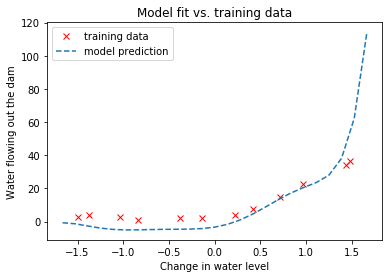

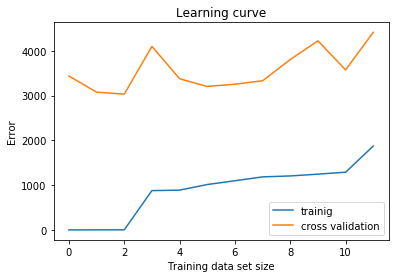

In [214]:
plot_pred_and_learncurve(0)

### Adjusting Regularization Parameter ($\lambda$)

In this section, you will get to observe how the regularization parameter
affects the bias-variance of regularized polynomial regression. You should
now modify the the lambda parameter in the ex5.m and try λ = 1, 100. For
each of these values, the script should generate a polynomial fit to the data
and also a learning curve.

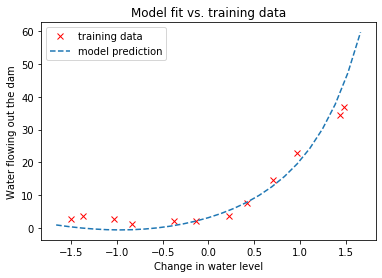

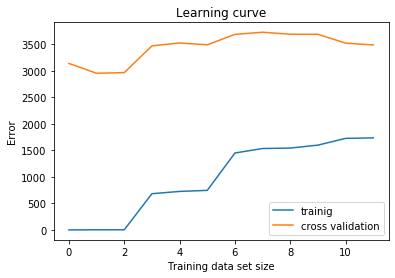

In [215]:
plot_pred_and_learncurve(1)

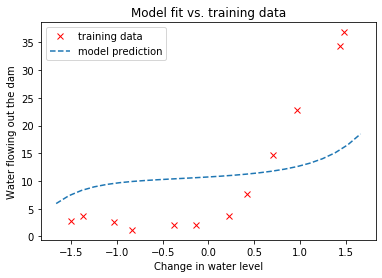

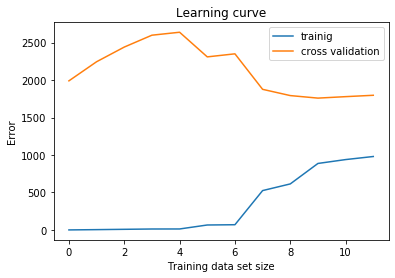

In [218]:
plot_pred_and_learncurve(100)

In [235]:
def get_regularization_curves(theta, x, y, lbda_vals, x_val, y_val):
    """
    Return errors of training and cross validation data sets for a series of lbda_vals.
    """

    # init
    # errors
    er_train = np.ones(len(lbda_vals))
    er_val = np.ones(len(lbda_vals))

    for i, lbda in enumerate(lbda_vals):
        # fit model
        tmp_result = reg_linreg_fit(theta, x, y, lbda)
        tmp_thetaopt = tmp_result["x"]

        # compute and store errors for fitted model with subsetted training data
        er_train[i] = reg_linreg_cost(tmp_thetaopt, x, y, lbda)

        # compute and store errors for fitted model with all cross validation data
        er_val[i] = reg_linreg_cost(tmp_thetaopt, x_val, y_val, lbda)

    return {"er_train": er_train, "er_val": er_val}

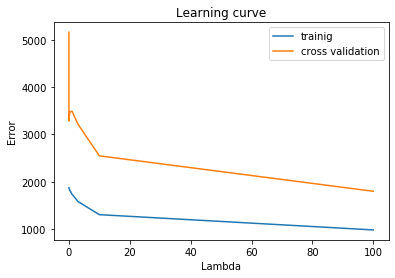

In [239]:
lbda_arr = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10,100])
lbda_learncurves = get_regularization_curves(
    theta_initpol, Xpol, y, lbda_arr, Xpol_val, yval
)

# visualize learning curves
plt.plot(lbda_arr,lbda_learncurves["er_train"])
plt.plot(lbda_arr,lbda_learncurves["er_val"])

plt.title("Learning curve")
plt.xlabel("Lambda")
plt.ylabel("Error")
plt.legend(labels=["trainig", "cross validation"])
plt.show()

### Check test set error

In [244]:
reg_linreg_cost(theta_opt, Xtest, ytest, 3)

3451.998510999993